In [1]:
import xml.etree.ElementTree as ET # parse xml anotation
import glob # grab files
import os # paths
import json # process json
import shutil # move file
from sklearn.model_selection import train_test_split # train test splitting
from tqdm.auto import tqdm # progress
import random # random sample of images
from PIL import Image, ImageDraw # draw on images
from IPython.display import display # display images on jupyter notebook
import numpy as np
# reproducibility
np.random.seed(42)
random.seed(42)


In [2]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]
def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

In [3]:
ls RDD2022_0/

China_Drone/      Czech/  Japan/   Norway1/
China_MotorBike/  India/  Norway/  United_States/


In [4]:
input_dir = "RDD2022_0/"
output_dir = "RDD2022_1"
classes = ["D00", "D10", "D20", "D40"]
train_countries = ["Czech", "India", "Japan", "Norway1", "United_States", "China_MotorBike", "China_Drone"]
test_countries = ["Czech", "India", "Japan", "Norway1", "United_States", "China_MotorBike"]

In [5]:
annotation_files = []
for c in train_countries:
    im_per_c = glob.glob(os.path.join(input_dir, c, "train/annotations/xmls/*.xml"))
    annotation_files += im_per_c

In [6]:
print(len(annotation_files))

38385


In [7]:
def convert_files(files, classes):
  converted_files = []
  for fil in tqdm(files):
      basename = os.path.basename(fil)
      filename = os.path.splitext(basename)[0]
      result = []
      # parse the content of the xml file
      tree = ET.parse(fil)
      root = tree.getroot()
      width = int(root.find("size").find("width").text)
      height = int(root.find("size").find("height").text)

      for obj in root.findall('object'):
          label = obj.find("name").text
          # check for new classes and append to list
          if label not in classes:
              continue
          index = classes.index(label)
          pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
          yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
          # convert data to string
          bbox_string = " ".join([str(x) for x in yolo_bbox])
          result.append(f"{index} {bbox_string}")

      if result:
          # generate a YOLO format text file for each xml file
          converted_file = os.path.join(os.path.dirname(fil), f"{filename}.txt")
          with open(converted_file, "w", encoding="utf-8") as f:
              f.write("\n".join(result))
          converted_files.append(converted_file)
  return converted_files

In [8]:
# convert
annotation_files = convert_files(annotation_files, classes)

In [9]:
len(annotation_files)

23700

In [10]:
# Do it for each country
for c in test_countries:
    files = glob.glob(os.path.join(input_dir, c, "train/annotations/xmls/", "*.txt"))
    print(os.path.join(input_dir, c, "train/annotations/xmls/"))
    print(f"{c}: {len(files)}")

RDD2022_0/Czech/train/annotations/xmls/
Czech: 1072
RDD2022_0/India/train/annotations/xmls/
India: 3223
RDD2022_0/Japan/train/annotations/xmls/
Japan: 7900
RDD2022_0/Norway1/train/annotations/xmls/
Norway1: 2847
RDD2022_0/United_States/train/annotations/xmls/
United_States: 4805
RDD2022_0/China_MotorBike/train/annotations/xmls/
China_MotorBike: 1934


In [11]:
# Create the directories
for c in test_countries:
    # train imagesinput
    os.makedirs(os.path.join(output_dir, c, "images/train"), exist_ok=True)
    # val images
    os.makedirs(os.path.join(output_dir, c, "images/val"), exist_ok=True)
    # train labels
    os.makedirs(os.path.join(output_dir, c, "labels/train"), exist_ok=True)
    # val labels
    os.makedirs(os.path.join(output_dir, c, "labels/val"), exist_ok=True)

In [12]:
# convert the path of annotation file to the original file
def anno_to_img(f):
    return os.path.join("/".join(f.split("/")[:3]), "images", os.path.splitext(os.path.basename(f))[0] + ".jpg")

In [13]:
def copy_for_country(c, new_size=None):
    c_annos = glob.glob(os.path.join(input_dir, c, "train/annotations/xmls/*.txt"))
    c_train_annos, c_val_annos = train_test_split(c_annos, test_size=0.1, shuffle=True)
    # add other countries in
    for o in train_countries:
        if o != c:
            c_train_annos += glob.glob(os.path.join(input_dir, o, "train/annotations/xmls/*.txt"))
    # now copy the train labels
    dest_dir = os.path.join(output_dir, c, "labels/train")
    for f in tqdm(c_train_annos):
        shutil.copy(f, dest_dir)
    # now copy the val labels
    dest_dir = os.path.join(output_dir, c, "labels/val")
    for f in tqdm(c_val_annos):
        shutil.copy(f, dest_dir)
    # now copy the train images
    dest_dir = os.path.join(output_dir, c, "images/train")
    for f in tqdm(c_train_annos):
        if new_size != None:
            img_path = anno_to_img(f)
            Image.open(img_path).resize((new_size, new_size)).save(os.path.join(dest_dir, os.path.basename(img_path)))
        else:
            shutil.copy(anno_to_img(f), dest_dir)
    # now copy the val images
    dest_dir = os.path.join(output_dir, c, "images/val")
    for f in tqdm(c_val_annos):
        if new_size != None:
            img_path = anno_to_img(f)
            Image.open(img_path).resize((new_size, new_size)).save(os.path.join(dest_dir, os.path.basename(img_path)))
        else:
            shutil.copy(anno_to_img(f), dest_dir)
    
    

In [14]:
new_size = None
for c in test_countries:
    copy_for_country(c, new_size)

In [15]:
def draw_image(img, bboxes, labels):
    draw = ImageDraw.Draw(img)
    for i, bbox in enumerate(bboxes):
        draw.rectangle(bbox, outline="red", width=2)
        draw.text([bbox[0], bbox[1]-12], labels[i])
    display(img)

In [16]:
def image_to_anno_file(image_filename):
  return os.path.join(output_dir,c, "labels/train/",  os.path.splitext(os.path.basename(image_filename))[0] + ".txt")  

In [17]:
def anno_to_image_file(anno_filename):
  return os.path.join(output_dir, c, "images/train/",  os.path.splitext(os.path.basename(anno_filename))[0] + ".jpg")    

In [18]:
# get all the train files up again
def get_train(c):
    file_train = glob.glob(os.path.join(output_dir,c, "labels/train", "*.txt"))
    return file_train

In [19]:
file_train = get_train("United_States")

In [20]:
anno_to_image_file(file_train[0])

'RDD2022_2/China_MotorBike/images/train/Japan_002263.jpg'

In [21]:
def draw_random_img():
  anno_files = file_train
  image_filename = anno_to_image_file(random.sample(anno_files, 1)[0])
  label_filename = image_to_anno_file(image_filename)
  bboxes = []
  labels = []
  img = Image.open(image_filename)
  if os.path.exists(label_filename):
    with open(label_filename, 'r', encoding='utf8') as f:
        for line in f:
            data = line.strip().split(' ')
            bbox = [float(x) for x in data[1:]]
            coords = yolo_to_xml_bbox(bbox, img.width, img.height)
            labels.append(classes[int(data[0])])
            bboxes.append(coords)
  draw_image(img, bboxes, labels)
  print(os.path.basename(image_filename))

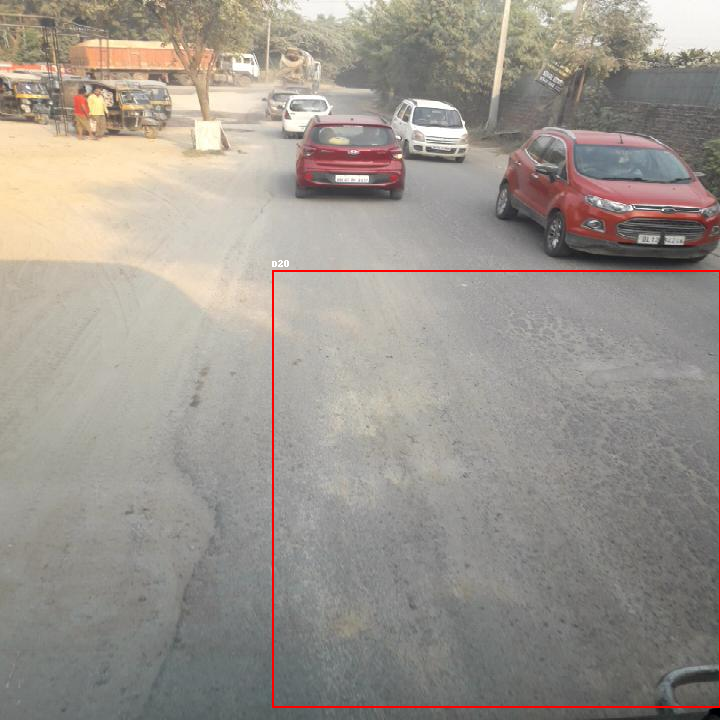

India_004348.jpg


In [22]:
draw_random_img()

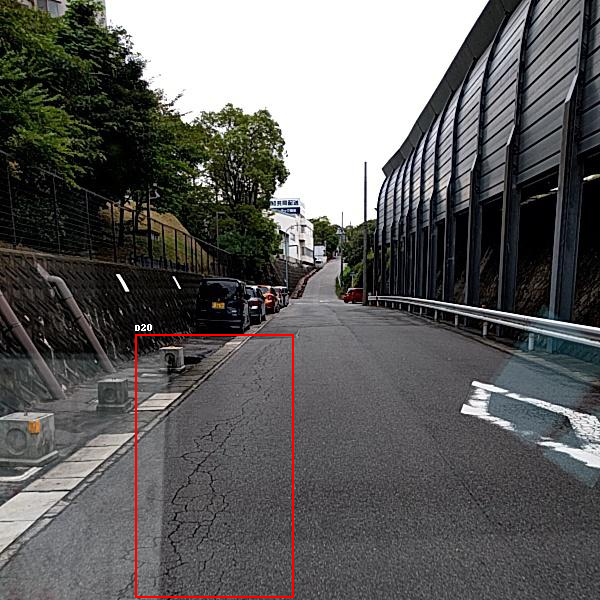

Japan_005402.jpg


In [23]:
draw_random_img()

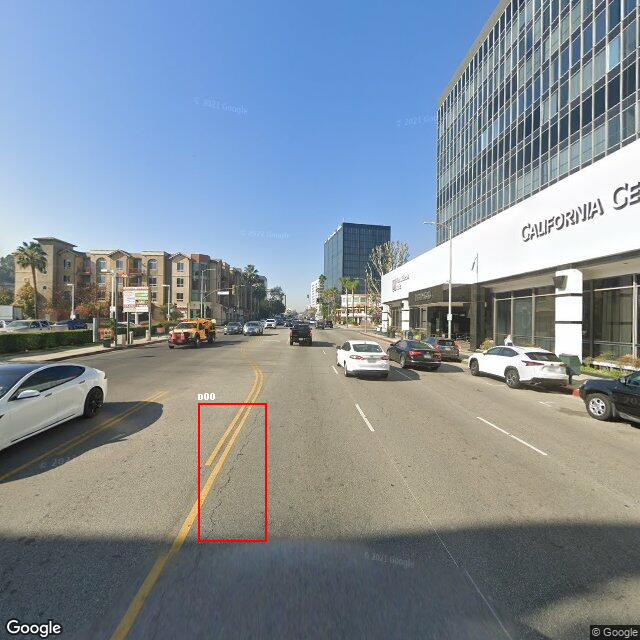

United_States_003246.jpg


In [24]:
draw_random_img()

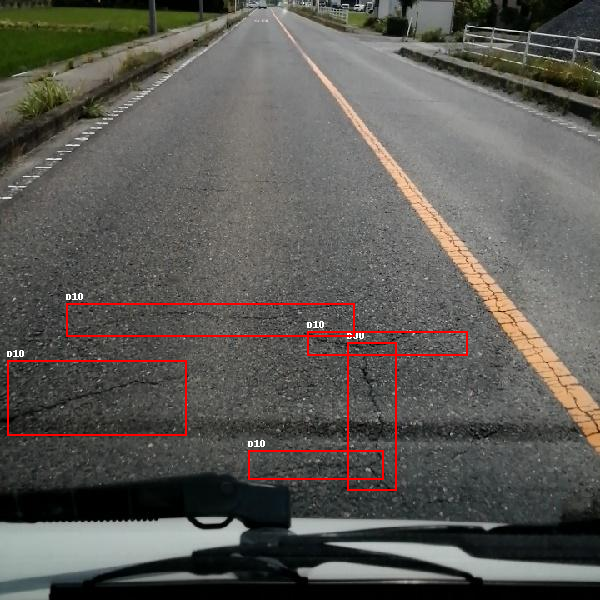

Japan_005290.jpg


In [25]:
draw_random_img()